<a href="https://colab.research.google.com/github/Ankush-kadu/Programming-Assignment-3-Hierarchical-Reinforcement-Learning-new/blob/main/FINAL_OE22S027_OE22S024_PA3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
from typing import Optional
import numpy as np
import gymnasium as gym

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [ ]:
!pip install gymnasium > /dev/null

# Setup

## Setup

In [ ]:
# env = gym.make("Taxi-v3")
# env.observation_space, env.action_space, env.reward_range, env.class_name(), env.metadata

## State/Action Helpers

In [ ]:
from dataclasses import dataclass
from typing import ClassVar


@dataclass
class State:
    taxi_row: int
    taxi_col: int
    passenger_location: int
    destination: int

    n_taxi_row: ClassVar[int] = 5
    n_taxi_col: ClassVar[int] = 5

    passenger_location_map: ClassVar[dict[int, str]] = {
        0: "Red",
        1: "Green",
        2: "Yellow",
        3: "Blue",
        4: "Taxi",
    }
    destination_location_map: ClassVar[dict[int, str]] = {
        0: "Red",
        1: "Green",
        2: "Yellow",
        3: "Blue",
    }

    color_to_loc_map: ClassVar[dict[int, tuple[int, int]]] = {
        0: (0, 0),  # Red
        1: (0, 4),  # Green
        2: (4, 0),  # Yellow
        3: (4, 3),  # Blue
    }

    N: ClassVar[int] = 500

    def __int__(self):
        # ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
        return (
            (self.taxi_row * 5 + self.taxi_col) * 5 + self.passenger_location
        ) * 4 + self.destination

    def to_int(self):
        return int(self)

    def __str__(self):
        return (
            f"(Loc: ({self.taxi_row}, {self.taxi_col}), "
            f"Passenger: {self.passenger_location_map[self.passenger_location]}, "
            f"Destination: {self.destination_location_map[self.destination]})"
        )

    @staticmethod
    def from_int(state: int):
        dest = state % 4
        state //= 4
        passenger_loc = state % 5
        state //= 5
        col = state % 5
        state //= 5
        row = state
        return State(row, col, passenger_loc, dest)


@dataclass
class Action:
    action: int

    action_map: ClassVar[dict[int, str]] = {
        0: "South",
        1: "North",
        2: "East",
        3: "West",
        4: "Pickup",
        5: "Dropoff",
    }

    verbose_action_map: ClassVar[dict[int, str]] = {
        0: "Move south(down)",
        1: "Move north(up)",
        2: "Move east(right)",
        3: "Move west(left)",
        4: "Pickup passenger",
        5: "Drop off passenger",
    }

    N: ClassVar[int] = len(action_map)

    def __int__(self):
        return self.action

    def to_int(self):
        return int(self)

    def __str__(self):
        return f"{self.action_map[self.action]}"

    @staticmethod
    def from_int(action: int):
        return Action(action)

In [ ]:
print("State:", State.from_int(404))
print("Action:", Action(3))

State: (Loc: (4, 0), Passenger: Green, Destination: Red)
Action: West


## Q Network

In [ ]:
import random
from typing import Optional

import numpy as np

In [ ]:
class QNetwork:
    def __init__(
        self,
        n_states: int,
        n_actions: int,
        gamma: float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        self.rng = random.Random(seed)

        self.n_states = n_states
        self.n_actions = n_actions

        self.q = np.zeros((n_states, n_actions))

        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon

    def start(self):
        pass

    def policy(self, state: int, eval=False):
        mask = np.ones((self.n_actions,))

        if eval or self.rng.random() > self.epsilon:
            return np.argmax((self.q[state, :] - self.q[state, :].min()) * mask)
        else:
            return self.rng.choice(np.where(mask == 1)[0])

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        done: bool,
        eval=False,
        tau=1,
    ):
        if not eval:
            self.q[state, action] += self.alpha * (
                reward
                + (self.gamma**tau) * self.q[next_state, :].max()
                - self.q[state, action]
            )

    def finish(self):
        pass

In [ ]:
class BasicQNetwork:
    def __init__(
        self,
        n_states: int,
        n_actions: int,
        gamma: float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        self.rng = random.Random(seed)

        self.n_states = n_states
        self.n_actions = n_actions

        self.q = np.zeros((n_states, n_actions))

        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon

    def start(self):
        pass

    def policy(self, state: int, eval=eval):
        mask = np.ones((self.n_actions,))

        if eval or self.rng.random() > self.epsilon:
            return np.argmax((self.q[state, :] - self.q[state, :].min()) * mask)
        else:
            # For some weird reason this line performs much better than the
            # actual implementation of random choice for base qlearning.
            # The following line gives only a False or True (NOT 0 or 1)
            return self.rng.choice(mask == 1)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        done: bool,
        eval=False,
        tau=1,
    ):
        if not eval:
            self.q[state, action] += self.alpha * (
                reward
                + (self.gamma**tau) * self.q[next_state, :].max()
                - self.q[state, action]
            )

    def finish(self):
        pass

In [ ]:
class IntraQNetwork:
    def __init__(
        self,
        n_states: int,
        n_options: int,
        gamma: float,
        beta : float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        self.rng = random.Random(seed)

        self.n_states = n_states
        self.n_options = n_options

        self.q = np.zeros((n_states, n_options))

        self.gamma = gamma
        self.beta = beta
        self.alpha = alpha
        self.epsilon = epsilon

    def start(self):
        pass

    def policy(self, state: int, mask: Optional[np.ndarray] = None, eval=False):

        if eval or self.rng.random() > self.epsilon:
            return np.argmax(self.q[state, :])
        else:
            return self.rng.choice(list(range(self.n_options)))

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        done: bool,
        eval=False,
    ):

        if not eval:
            self.q[state, action] += self.alpha * (
                reward
                + self.gamma * ((1-self.beta)*self.q[next_state,action]+
                                  (self.beta)*self.q[next_state,:].max()
                - self.q[state, action])
            )

    def finish(self):
        pass


## Primitive Option Net

In [ ]:
class Option:
    def __init__(self):
        self._done = True
        pass

    def start(self):
        self._done = False
        return self

    def policy(self, state, action_mask=None, eval=False):
        raise NotImplementedError

    def update(self, state, action, reward, next_state, done, eval=False):
        pass

    def finish(self):
        pass

    def is_done(self):
        return self._done



class PrimitiveOption(Option):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def policy(self, state, action_mask=None, eval=False):
        self._done = True
        return self.action

    def __str__(self):
        return f"PrimitiveOption: {Action.action_map[self.action]}"

In [ ]:
class PrimitiveOptionNet:
    def __init__(
        self,
        n_states: int,
        n_actions: int,
        gamma: float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        self.n_states = n_states
        self.n_options = n_actions
        self.options = [PrimitiveOption(ac) for ac in range(n_actions)]
        self.option = None
        self.option_id = None
        self.option_start_state = None
        self.tau = None
        self.r_bar = None

        self.gamma = gamma
        self.net = QNetwork(n_states, self.n_options, gamma, alpha, epsilon, seed)

    def start(self):
        self.option = None

    def policy(self, state: int, mask: Optional[np.ndarray] = None, eval=False):
        # Choose new option if required
        if self.option is None:
            # if mask is None:
            mask = np.ones((self.n_options,))
            # else:
            #     mask = np.array(mask)
            self.option_id = self.net.policy(state, eval=eval)
            self.option = self.options[self.option_id]
            self.option.start()
            self.option_start_state = state
            self.r_bar = 0.0
            self.tau = 0

        return self.option.policy(state, mask, eval=eval)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        done: bool,
        eval=False,
    ):
        assert self.option is not None

        self.option.update(state, action, reward, next_state, done, eval)

        self.r_bar += (self.gamma**self.tau) * reward
        self.tau += 1

        # Finish option if done
        if self.option.is_done():
            self.option.finish()
            self.option = None

            self.net.update(
                self.option_start_state, self.option_id, self.r_bar, next_state, done, eval, tau=self.tau
            )

    def finish(self):
        self.option = None

## Color Option Net

In [ ]:
class ColorOption(Option):
    def __init__(
        self,
        loc: tuple[int, int],
        gamma: float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        super().__init__()
        self.loc = loc
        self.terminal = loc[0] * State.n_taxi_col + loc[1]
        self.n_lower_states = State.n_taxi_row * State.n_taxi_col
        self.n_lower_actions = 4
        self.net = QNetwork(
            self.n_lower_states, self.n_lower_actions, gamma, alpha, epsilon, seed
        )

    @staticmethod
    def to_lower_state(state):
        s = State.from_int(state)
        return s.taxi_row * State.n_taxi_col + s.taxi_col

    def to_lower_mask(self, mask):
        return mask[: self.n_lower_actions]

    @staticmethod
    def to_higher_action(action):
        return action

    @staticmethod
    def to_lower_action(action):
        return action

    def policy(self, state, action_mask=None, eval=False):
        # if action_mask is None:
        action_mask = np.ones(6)
        action_mask = self.to_lower_mask(action_mask)

        state = self.to_lower_state(state)

        action = self.net.policy(state, eval=eval)
        return self.to_higher_action(action)

    def update(self, state, action, reward, next_state, done, eval=False):
        state = self.to_lower_state(state)
        action = self.to_lower_action(action)
        next_state = self.to_lower_state(next_state)

        reward = -1
        if next_state == self.terminal:
            self._done = True
            reward = 10

        self.net.update(state, action, reward, next_state, done, eval)

    def __str__(self):
        index = list(State.color_to_loc_map.keys())[list(State.color_to_loc_map.values()).index(self.loc)]
        return f"ColorOption: {State.destination_location_map[index]}"

In [ ]:
class ColorOptionNet:
    def __init__(
            self,
            n_states: int,
            n_actions: int,
            gamma: float,
            alpha: float,
            epsilon: float,
            seed: int,
    ):


        self.rng = random.Random(seed)

        self.loc_ids = list(State.color_to_loc_map.keys())
        self.loc_list = list(State.color_to_loc_map.values())
        self.n_taxi_states = len(self.loc_list) + 1

        self.n_states = \
            self.n_taxi_states * \
            len(State.passenger_location_map) * \
            len(State.destination_location_map)

        self.n_options = len(self.loc_list) + 2

        self.options = []
        self.options.extend(
            ColorOption(loc, gamma, alpha, epsilon, seed=self.rng.getrandbits(32))
            for loc in self.loc_list
        )
        self.options.extend(PrimitiveOption(ac) for ac in (4, 5))
        self.option: Optional[Option] = None
        self.option_id = None

        self.l_start_state = None
        self.tau = None
        self.r_bar = None

        self.gamma = gamma
        self.net = QNetwork(
            self.n_states,
            self.n_options,
            gamma,
            alpha,
            epsilon,
            seed=self.rng.getrandbits(32),
        )

    def start(self):
        # print("=== EP Start ===")
        self.option = None

    def to_lower_state(self, state):
        s = State.from_int(state)

        loc = (s.taxi_row, s.taxi_col)
        loci = None

        if loc in self.loc_list:
            loci = self.loc_ids[self.loc_list.index(loc)]
        else:
            loci = self.n_taxi_states - 1  # other

        return (
                (loci
                 * len(State.passenger_location_map) + s.passenger_location)
                * len(State.destination_location_map) + s.destination
        )

    def policy(self, state: int, mask: Optional[np.ndarray] = None, eval=False):
        if self.option is None:
            low_state = self.to_lower_state(state)
            # print(self.net.q[state, :])
            option_mask = [1, 1, 1, 1, 1, 1]
            self.option_id = self.net.policy(low_state, eval=eval)
            self.option = self.options[self.option_id]
            # print("== Start ", self.option_id, self.option)
            self.option.start()
            self.l_start_state = low_state
            self.r_bar = 0.0
            self.tau = 0

        return self.option.policy(state, mask, eval=eval)

    def update(
            self,
            state: int,
            action: int,
            reward: float,
            next_state: int,
            done: bool,
            eval=False,
    ):
        assert self.option is not None

        self.option.update(state, action, reward, next_state, done, eval)

        self.r_bar += (self.gamma ** self.tau) * reward
        self.tau += 1

        if self.option.is_done():
            self.option.finish()
            # print("== End ", self.option, self.tau)
            self.option = None

            l_next_state = self.to_lower_state(next_state)
            self.net.update(
                self.l_start_state, self.option_id, self.r_bar, l_next_state, done, eval, tau=self.tau
            )

    def finish(self):
        # print("=== EP End ===")
        self.option = None


## Passenger Pick/Drop Option Net

In [ ]:
class PickOption(Option):
    def __init__(
        self,
        gamma: float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        super().__init__()
        self.n_lower_states = State.n_taxi_row * State.n_taxi_col * len(State.passenger_location_map)
        self.n_lower_actions = 5
        self.net = QNetwork(
            self.n_lower_states, self.n_lower_actions, gamma, alpha, epsilon, seed
        )

    @staticmethod
    def to_lower_state(state):
        s = State.from_int(state)
        return ((s.passenger_location * State.n_taxi_row + s.taxi_row ) * State.n_taxi_col + s.taxi_col)

    def to_lower_mask(self, mask):
        raise NotImplementedError()

    @staticmethod
    def to_higher_action(action):
        return action

    @staticmethod
    def to_lower_action(action):
        return action

    def policy(self, state, action_mask=None, eval=False):
        lstate = self.to_lower_state(state)
        action = self.net.policy(lstate, eval=eval)
        return self.to_higher_action(action)

    def update(self, state, action, reward, next_state, done, eval=False):
        lstate = self.to_lower_state(state)
        laction = self.to_lower_action(action)
        lnext_state = self.to_lower_state(next_state)

        s = State.from_int(next_state)
        if s.passenger_location == 4:
            self._done = True
            reward += 11

        self.net.update(lstate, laction, reward, lnext_state, done, eval)

    def __str__(self):
        return f"Pickup Option"

In [ ]:
class DropOption(Option):
    def __init__(
        self,
        gamma: float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        super().__init__()
        self.n_lower_states = State.n_taxi_row * State.n_taxi_col * len(State.destination_location_map)
        self.n_lower_actions = 5
        self.net = QNetwork(
            self.n_lower_states, self.n_lower_actions, gamma, alpha, epsilon, seed
        )

    @staticmethod
    def to_lower_state(state):
        s = State.from_int(state)
        return ((s.destination * State.n_taxi_row + s.taxi_row )* State.n_taxi_col + s.taxi_col)

    def to_lower_mask(self, mask):
        raise NotImplementedError()

    @staticmethod
    def to_higher_action(action):
        return action if action < 4 else 5

    @staticmethod
    def to_lower_action(action):
        return action if action < 4 else 4

    def policy(self, state, action_mask=None, eval=False):
        lstate = self.to_lower_state(state)
        action = self.net.policy(lstate, eval=eval)
        return self.to_higher_action(action)

    def update(self, state, action, reward, next_state, done, eval=False):
        lstate = self.to_lower_state(state)
        laction = self.to_lower_action(action)
        lnext_state = self.to_lower_state(next_state)

        s = State.from_int(next_state)
        if s.passenger_location != 4:
            self._done = True

        self.net.update(lstate, laction, reward, lnext_state, done, eval)

    def __str__(self):
        return f"Dropoff Option"

In [ ]:
class PickDropNet:
    def __init__(
            self,
            n_states: int,
            n_actions: int,
            gamma: float,
            alpha: float,
            epsilon: float,
            seed: int,
    ):


        self.rng = random.Random(seed)


        self.n_states = 2
        self.n_options = 2

        self.options = [
            PickOption(gamma, alpha, epsilon, seed=self.rng.getrandbits(32)),
            DropOption(gamma, alpha, epsilon, seed=self.rng.getrandbits(32))
        ]

        self.option: Optional[Option] = None
        self.option_id = None

        self.l_start_state = None
        self.tau = None
        self.r_bar = None

        self.gamma = gamma
        self.net = QNetwork(
            self.n_states,
            self.n_options,
            gamma,
            alpha,
            epsilon,
            seed=self.rng.getrandbits(32),
        )

    def start(self):
        # print("=== EP Start ===")
        self.option = None

    def to_lower_state(self, state):
        s = State.from_int(state)
        return int(s.passenger_location == 4)

    def policy(self, state: int, mask: Optional[np.ndarray] = None, eval=False):
        if self.option is None:
            s = State.from_int(state)

            low_state = self.to_lower_state(state)
            self.option_id = self.net.policy(low_state, eval=eval)
            self.option = self.options[self.option_id]

            self.option.start()
            self.l_start_state = low_state
            self.r_bar = 0.0
            self.tau = 0

        return self.option.policy(state, eval=eval)

    def update(
            self,
            state: int,
            action: int,
            reward: float,
            next_state: int,
            done: bool,
            eval=False,
    ):
        assert self.option is not None

        self.option.update(state, action, reward, next_state, done, eval)

        self.r_bar += (self.gamma ** self.tau) * reward
        self.tau += 1

        # if done or self.option.is_done():
        if self.option.is_done():
            self.option.finish()

            self.option = None

            l_next_state = self.to_lower_state(next_state)
            self.net.update(
                self.l_start_state, self.option_id, self.r_bar, l_next_state, done, eval, tau=self.tau
            )

    def finish(self):
        # print("=== EP End ===")
        self.option = None


## Color Intra Option Net

In [ ]:
class ColorIntraOption(Option):
    def __init__(
        self,
        loc: tuple[int, int],
        gamma: float,
        beta : float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        super().__init__()
        self.loc = loc
        self.terminal = loc[0] * State.n_taxi_col + loc[1]
        self.n_lower_states = State.n_taxi_row * State.n_taxi_col
        self.n_lower_actions = 4
        self.net = IntraQNetwork(
            self.n_lower_states, self.n_lower_actions, gamma, beta, alpha, epsilon, seed
        )

    @staticmethod
    def to_lower_state(state):
        s = State.from_int(state)
        return s.taxi_row * State.n_taxi_col + s.taxi_col

    @staticmethod
    def to_higher_action(action):
        return action

    @staticmethod
    def to_lower_action(action):
        return action

    def policy(self, state, eval=False):
        state = self.to_lower_state(state)

        action = self.net.policy(state, eval=eval)
        return self.to_higher_action(action)

    def update(self, state, action, reward, next_state, done, eval=False):
        state = self.to_lower_state(state)
        action = self.to_lower_action(action)
        next_state = self.to_lower_state(next_state)

        reward = -1
        if next_state == self.terminal:
            self._done = True
            reward = 10

        self.net.update(state, action, reward, next_state, done, eval)

    def __str__(self):
        index = list(State.color_to_loc_map.keys())[list(State.color_to_loc_map.values()).index(self.loc)]
        return f"ColorIntraOption: {State.destination_location_map[index]}"

In [ ]:
class ColorIntraOptionNet:
    def __init__(
            self,
            n_states: int,
            n_actions: int,
            gamma: float,
            beta : float,
            alpha: float,
            epsilon: float,
            seed: int,
    ):


        self.rng = random.Random(seed)

        self.loc_ids = list(State.color_to_loc_map.keys())
        self.loc_list = list(State.color_to_loc_map.values())
        self.n_taxi_states = len(self.loc_list) + 1

        self.n_states = \
            self.n_taxi_states * \
            len(State.passenger_location_map) * \
            len(State.destination_location_map)

        self.n_options = len(self.loc_list) + 2

        self.options = []
        self.options.extend(
            ColorIntraOption(loc, gamma, beta, alpha, epsilon, seed=self.rng.getrandbits(32))
            for loc in self.loc_list
        )
        self.options.extend(PrimitiveOption(ac) for ac in (4, 5))
        self.option: Optional[Option] = None
        self.option_id = None

        self.l_start_state = None
        self.r_bar = None

        self.gamma = gamma
        self.beta = beta
        self.net = IntraQNetwork(
            self.n_states,
            self.n_options,
            gamma,
            beta,
            alpha,
            epsilon,
            seed=self.rng.getrandbits(32),
        )

    def start(self):
        self.option = None

    def to_lower_state(self, state):
        s = State.from_int(state)

        loc = (s.taxi_row, s.taxi_col)

        if loc in self.loc_list:
            loci = self.loc_ids[self.loc_list.index(loc)]
        else:
            loci = self.n_taxi_states - 1  # other

        return (
                (loci
                 * len(State.passenger_location_map) + s.passenger_location)
                * len(State.destination_location_map) + s.destination
        )

    def policy(self, state: int, eval=False):
        if self.option is None:
            low_state = self.to_lower_state(state)

            self.option_id = self.net.policy(low_state,  eval=eval)

            self.option = self.options[self.option_id]
            self.option.start()
            self.l_start_state = low_state
            self.r_bar = 0.0

        return self.option.policy(state, eval=eval)

    def update(
            self,
            state: int,
            action: int,
            reward: float,
            next_state: int,
            done: bool,
            eval=False,
    ):
        assert self.option is not None

        self.option.update(state, action, reward, next_state, done, eval)

        self.r_bar +=  reward
        if self.option.is_done():
            self.option.finish()
            self.option = None

            l_next_state = self.to_lower_state(next_state)
            self.net.update(
                self.l_start_state, self.option_id, self.r_bar, l_next_state, done, eval
            )

    def finish(self):
        self.option = None


## Pick / Drop Intra Option

In [ ]:
class PickIntraOption(Option):
    def __init__(
        self,
        gamma: float,
        beta : float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        super().__init__()
        self.n_lower_states = State.n_taxi_row * State.n_taxi_col * len(State.passenger_location_map)
        self.n_lower_actions = 5
        self.net = IntraQNetwork(
            self.n_lower_states, self.n_lower_actions, gamma, beta , alpha, epsilon, seed
        )

    @staticmethod
    def to_lower_state(state):
        s = State.from_int(state)
        return ((s.passenger_location * State.n_taxi_row + s.taxi_row ) * State.n_taxi_col + s.taxi_col)

    @staticmethod
    def to_higher_action(action):
        return action

    @staticmethod
    def to_lower_action(action):
        return action

    def policy(self, state, eval=False):
        lstate = self.to_lower_state(state)
        action = self.net.policy(lstate, eval=eval)
        return self.to_higher_action(action)

    def update(self, state, action, reward, next_state, done, eval=False):
        lstate = self.to_lower_state(state)
        laction = self.to_lower_action(action)
        lnext_state = self.to_lower_state(next_state)

        s = State.from_int(next_state)
        if s.passenger_location == 4:
            self._done = True
            reward += 11

        self.net.update(lstate, laction, reward, lnext_state, done, eval)

    def __str__(self):
        return f"Pickup Option"

In [ ]:
class DropIntraOption(Option):
    def __init__(
        self,
        gamma: float,
        beta : float,
        alpha: float,
        epsilon: float,
        seed: int,
    ):
        super().__init__()
        self.n_lower_states = State.n_taxi_row * State.n_taxi_col * len(State.destination_location_map)
        self.n_lower_actions = 5
        self.net = IntraQNetwork(
            self.n_lower_states, self.n_lower_actions, gamma, beta, alpha, epsilon, seed
        )

    @staticmethod
    def to_lower_state(state):
        s = State.from_int(state)
        return ((s.destination * State.n_taxi_row + s.taxi_row )* State.n_taxi_col + s.taxi_col)

    @staticmethod
    def to_higher_action(action):
        return action if action < 4 else 5

    @staticmethod
    def to_lower_action(action):
        return action if action < 4 else 4

    def policy(self, state, eval=False):
        lstate = self.to_lower_state(state)
        action = self.net.policy(lstate, eval=eval)
        return self.to_higher_action(action)

    def update(self, state, action, reward, next_state, done, eval=False):
        lstate = self.to_lower_state(state)
        laction = self.to_lower_action(action)
        lnext_state = self.to_lower_state(next_state)

        s = State.from_int(next_state)
        if s.passenger_location != 4:
            self._done = True

        self.net.update(lstate, laction, reward, lnext_state, done, eval)

    def __str__(self):
        return f"Dropoff Option"

In [ ]:
class PickDropIntraNet:
    def __init__(
            self,
            n_states: int,
            n_actions: int,
            gamma: float,
            beta: float,
            alpha: float,
            epsilon: float,
            seed: int,
    ):


        self.rng = random.Random(seed)


        self.n_states = 2
        self.n_options = 2

        self.options = [
            PickIntraOption(gamma, beta, alpha, epsilon, seed=self.rng.getrandbits(32)),
            DropIntraOption(gamma, beta, alpha, epsilon, seed=self.rng.getrandbits(32))
        ]

        self.option: Optional[Option] = None
        self.option_id = None
        self.r_bar = None
        self.l_start_state = None
        self.beta = beta
        self.gamma = gamma
        self.net = IntraQNetwork(
            self.n_states,
            self.n_options,
            gamma,
            beta,
            alpha,
            epsilon,
            seed=self.rng.getrandbits(32),
        )

    def start(self):
        # print("=== EP Start ===")
        self.option = None

    def to_lower_state(self, state):
        s = State.from_int(state)
        return int(s.passenger_location == 4)

    def policy(self, state: int, eval=False):
        if self.option is None:
            s = State.from_int(state)

            low_state = self.to_lower_state(state)
            self.option_id = self.net.policy(low_state, eval=eval)
            self.option = self.options[self.option_id]

            self.option.start()
            self.l_start_state = low_state
            self.r_bar = 0.0

        return self.option.policy(state, eval=eval)

    def update(
            self,
            state: int,
            action: int,
            reward: float,
            next_state: int,
            done: bool,
            eval=False,
    ):
        assert self.option is not None

        self.option.update(state, action, reward, next_state, done, eval)

        self.r_bar += reward
        # if done or self.option.is_done():
        if self.option.is_done():
            self.option.finish()

            self.option = None

            l_next_state = self.to_lower_state(next_state)
            self.net.update(
                self.l_start_state, self.option_id, self.r_bar, l_next_state, done, eval
            )

    def finish(self):
        # print("=== EP End ===")
        self.option = None


## Runner

In [ ]:
def runner(net, N_ep, rng, eval=False, do_test=None, bar=True):
    test = False
    if do_test is not None:
        test = True
        test_interval = do_test['interval']
        test_iter = do_test['iter']
        test_seed = do_test['seed']
        test_s = np.zeros((N_ep // test_interval + 1, 2))


    env = gym.make("Taxi-v3")

    rewards_s = np.zeros(N_ep)
    steps_s = np.zeros(N_ep)

    for i in (tr := trange(N_ep) if bar else range(N_ep)):
        state, info = env.reset(seed=rng.getrandbits(32))
        done = False
        action_mask = info["action_mask"]
        tot_rew = 0
        steps = 0
        net.start()
        # print(State.from_int(state))
        while not done:
            action = net.policy(state, eval=eval)
            # action = int(action)
            # Basic QNetwork gives a bool here, and for some reason gives much better performance

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            action_mask = info["action_mask"]
            tot_rew += reward
            steps += 1

            net.update(state, action, reward, next_state, done, eval=eval)
            state = next_state
        net.finish()
        steps_s[i] = steps
        rewards_s[i] = tot_rew
        # if i % (N_ep / 100)  == 0:
        # tr.write(f"{i}:\t{tot_rew} in {steps}")

        if test and ((i % test_interval) == 0 or i == (N_ep-1)):
            test_rng = random.Random(test_seed)
            tr_s, ts_s = runner(net, N_ep=test_iter, rng=test_rng, eval=True, bar=False)
            test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())

    if test:
        return rewards_s, steps_s, test_s
    return rewards_s, steps_s

In [ ]:
def plot_test_performance(test_param, t_s):
    f, axs = plt.subplots(2, figsize=(20, 4), sharex=True)
    f.suptitle(f"Test performance averaged over {test_param['iter']} runs.")
    axs[0].set_ylabel("Percent Success")
    axs[1].set_ylabel("Average Successful Reward")
    axs[1].set_xlabel("Episodes")

    eps = np.arange(t_s.shape[0]) * test_param["interval"]


    axs[0].plot(eps, 1 - t_s[:, 0], 'o-')
    axs[1].plot(eps, t_s[:, 1], 'o-')

    axs[0].set_ylim(0, 1)
    axs[1].set_ylim(0, 15)
    # axs[1].set_ylim(0, axs[1].get_ylim()[1])

In [ ]:
def plot_perf(r_s, s_s, test_param, t_s, win=100, title=None):
    f, axss = plt.subplots(2, 2, figsize=(20, 4), sharex=True)

    axs = axss[:, 0]
    axs[0].set_title(f"Test performance averaged over {test_param['iter']} runs.")
    axs[0].set_ylabel("Percent Success")
    axs[1].set_ylabel("Average Successful Reward")
    axs[1].set_xlabel("Episodes")

    eps = np.arange(t_s.shape[0]) * test_param["interval"]

    axs[0].plot(eps, 1 - t_s[:, 0], 'o-')
    axs[1].plot(eps, t_s[:, 1], 'o-')

    axs[0].set_ylim(0, 1)
    axs[1].set_ylim(0, 15)


    axs = axss[:, 1]
    axs[0].set_title(f"Averaged over {win} iterations.")
    axs[0].set_ylabel("Reward")
    axs[1].set_ylabel("Steps")
    axs[1].set_xlabel("Reward")

    axs[0].plot(mavg(r_s, win))
    axs[1].plot(mavg(s_s, win))

    if title is not None:
        f.suptitle(title)

In [ ]:
def plot_all_perf(name_s, r_s_s, s_s_s, test_param, t_s_s, win=100, title=None):
    f, axss = plt.subplots(2, 2, figsize=(20, 4), sharex=True)

    for name, r_s, s_s, t_s in zip(name_s, r_s_s, s_s_s, t_s_s):
        axs = axss[:, 0]
        eps = np.arange(t_s.shape[0]) * test_param["interval"]
        axs[0].plot(eps, 1 - t_s[:, 0], 'o-')
        axs[1].plot(eps, t_s[:, 1], 'o-')
        axs = axss[:, 1]
        artist = axs[0].plot(mavg(r_s, win), label=name)


    axs = axss[:, 0]
    axs[0].set_title(f"Test performance averaged over {test_param['iter']} runs.")
    axs[0].set_ylabel("Percent Success")
    axs[1].set_ylabel("Average Successful Reward")
    axs[1].set_xlabel("Episodes")
    axs[0].set_ylim(0, 1.1)
    axs[1].set_ylim(0, 15)

    axs = axss[:, 1]
    axs[0].set_title(f"Averaged over {win} iterations.")
    axs[0].set_ylabel("Reward")

    axs[1].legend(*axs[0].get_legend_handles_labels(), loc='center')
    axs[1].axis('off')

    if title is not None:
        f.suptitle(title)

In [ ]:
def show_option_eval(net, seed=44):
    env = gym.make("Taxi-v3", render_mode="ansi")

    rng = random.Random(seed)
    state, info = env.reset(seed=rng.getrandbits(32))
    action_mask = info["action_mask"]
    done = False
    tot_rew = 0

    net.start()
    print(env.render())

    while not done:
        new_opt = net.option is None
        action = net.policy(state, action_mask, eval=True)
        if new_opt:
            print("New option:", net.option)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        action_mask = info["action_mask"]

        tot_rew += reward
        opt = net.option
        tau = net.tau
        net.update(state, action, reward, next_state, done, eval=True)

        if opt.is_done():
            print(State.from_int(state), opt, reward, tau + 1, sep="\t")
            print(env.render())
            print()

        state = next_state

    net.finish()

    print(env.render())
    print(State.from_int(state), "None", 0.0, action_mask, tau + 1, sep="\t")
    print(f"Reward: {tot_rew}")

## Gen

In [ ]:
n_states = State.N  # (500) Though only 400 can be reached
n_actions = Action.N  # 6
q_shape = (n_states, n_actions)

In [ ]:
def mavg(data, win):
    padded_x = np.pad(data, (win // 2, win // 2), mode="edge")
    return np.convolve(np.ones(win) / win, padded_x, mode="valid")

# Running

In [ ]:
curves: dict[str, tuple[np.ndarray, np.ndarray, np.ndarray]] = {}

test_param={
    "interval": 500,
    "iter": 100,
    "seed": 300,
}

N_ep = 3_000
seed = 475

## Basic QLearning

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


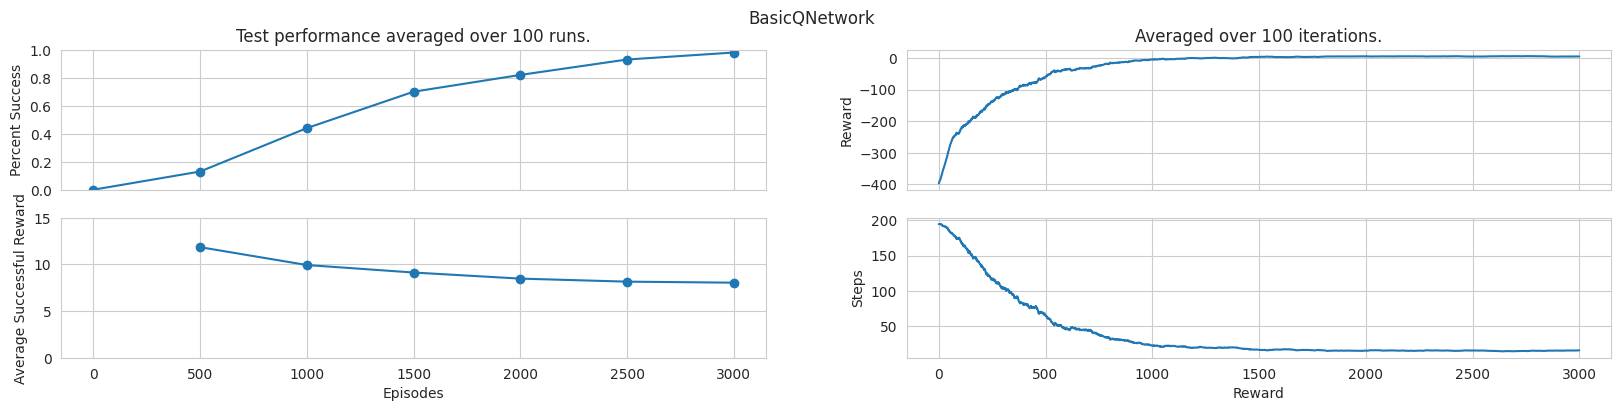

In [ ]:
rng = random.Random(seed)
net = BasicQNetwork(
    n_states, n_actions, gamma=0.9, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='BasicQNetwork')
curves["Basic Q-Network"] = (r_s, s_s, t_s)

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())


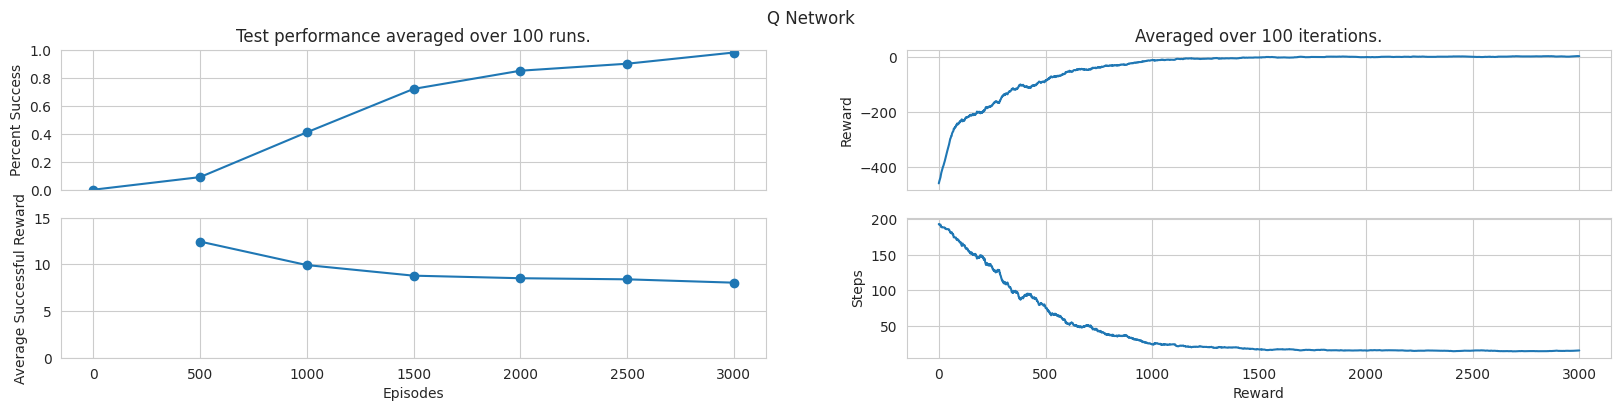

In [ ]:
rng = random.Random(seed)
net = QNetwork(
    n_states, n_actions, gamma=0.9, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='Q Network')

curves["Q-Network"] = (r_s, s_s, t_s)

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())


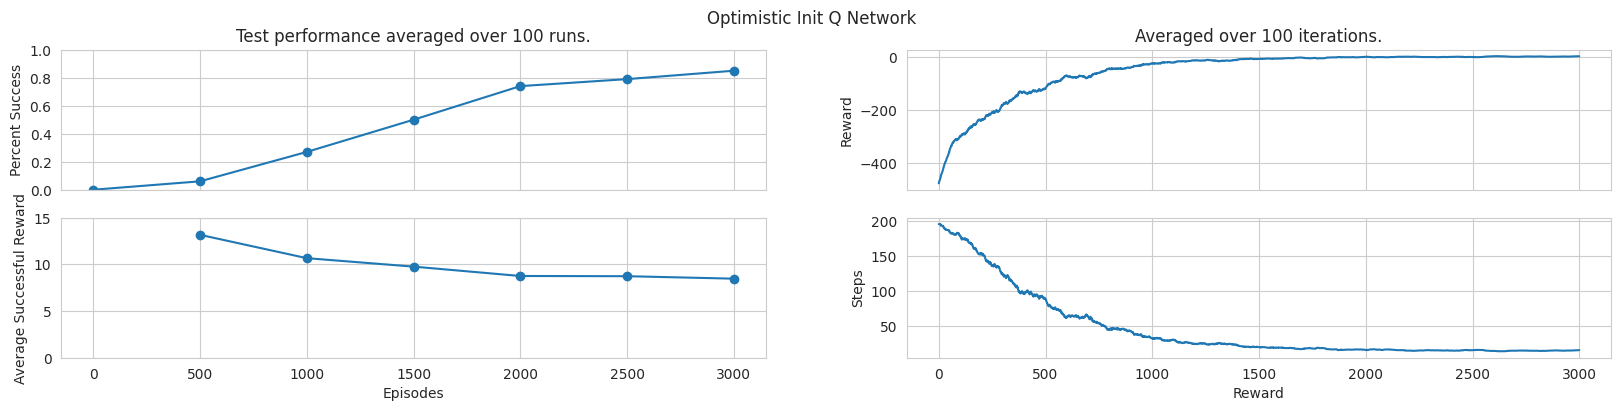

In [ ]:
rng = random.Random(seed)
net = QNetwork(
    n_states, n_actions, gamma=0.9, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)
net.q[:, :] += 10

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='Optimistic Init Q Network')

curves["Optimistic Q-Network"] = (r_s, s_s, t_s)

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())


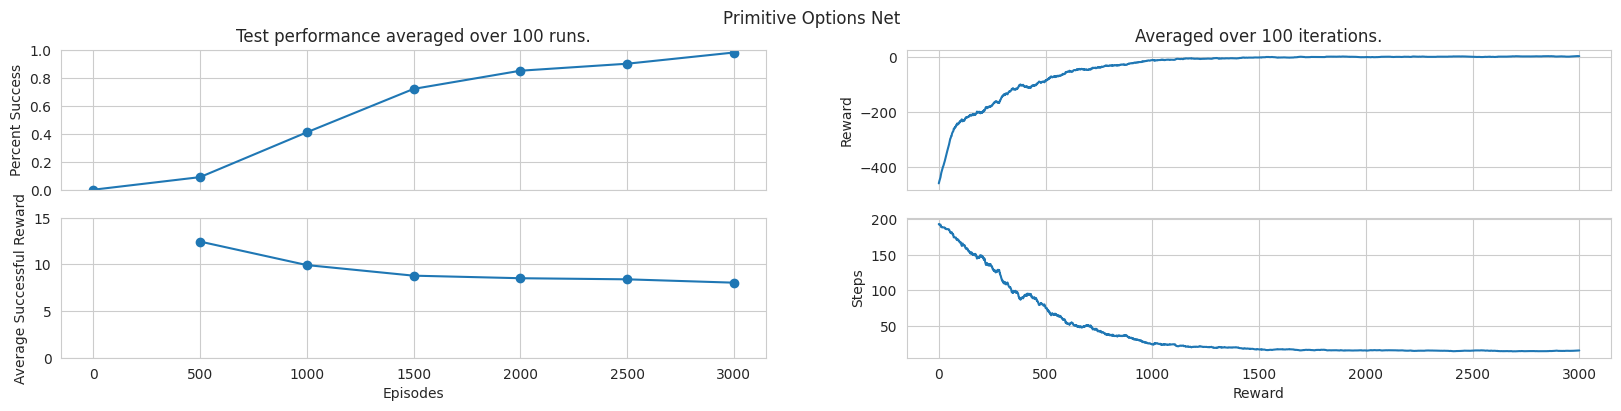

In [ ]:
rng = random.Random(seed)
net = PrimitiveOptionNet(
    n_states, n_actions, gamma=0.9, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='Primitive Options Net')

curves["SMDP with Primitive Options"] = (r_s, s_s, t_s)

## SMDP Learning

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())


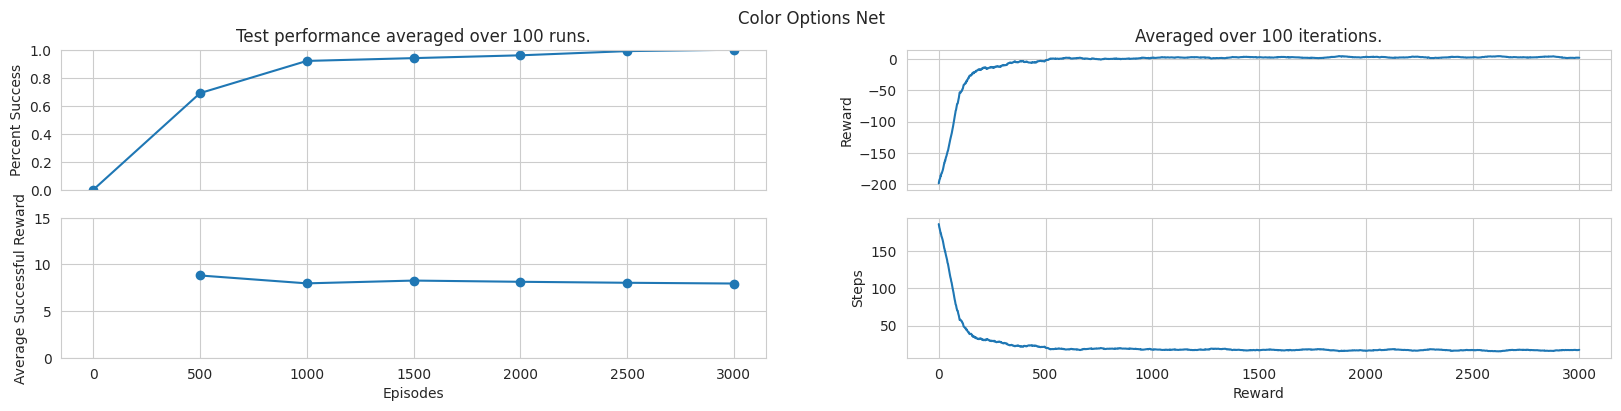

In [ ]:
rng = random.Random(seed)
net = ColorOptionNet(
    n_states, n_actions, gamma=0.9, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='Color Options Net')

curves["SMDP with Color Options"] = (r_s, s_s, t_s)

from copy import deepcopy
color_options_net = deepcopy(net)

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())


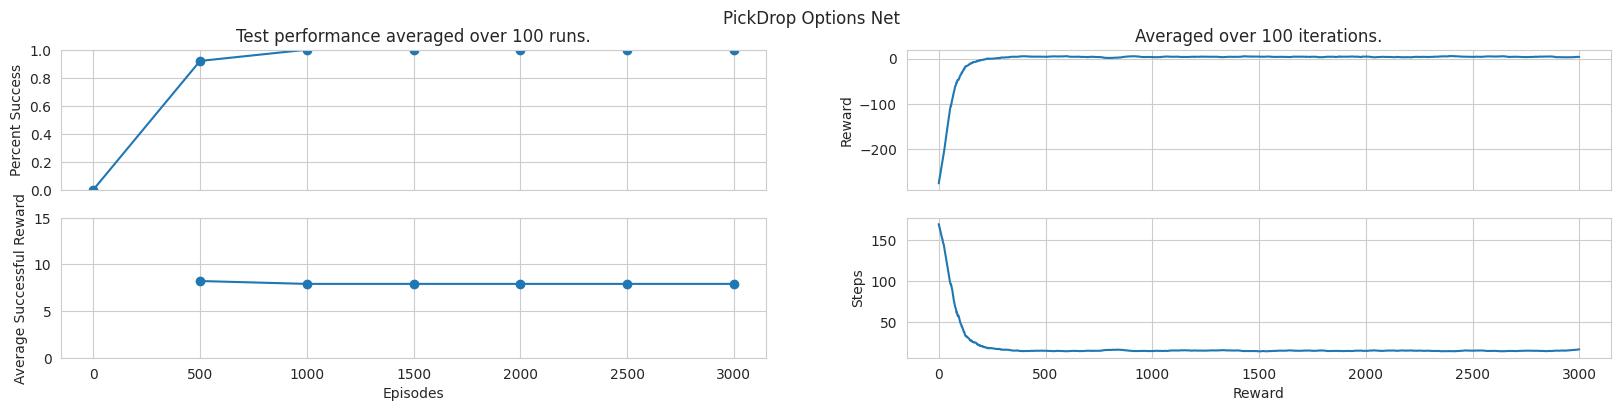

In [ ]:
rng = random.Random(seed)
net = PickDropNet(
    n_states, n_actions, gamma=0.9, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='PickDrop Options Net')

curves["SMDP with PickDrop Options"] = (r_s, s_s, t_s)

from copy import deepcopy
pickdrop_options_net = deepcopy(net)

## Intra Option Learning

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())


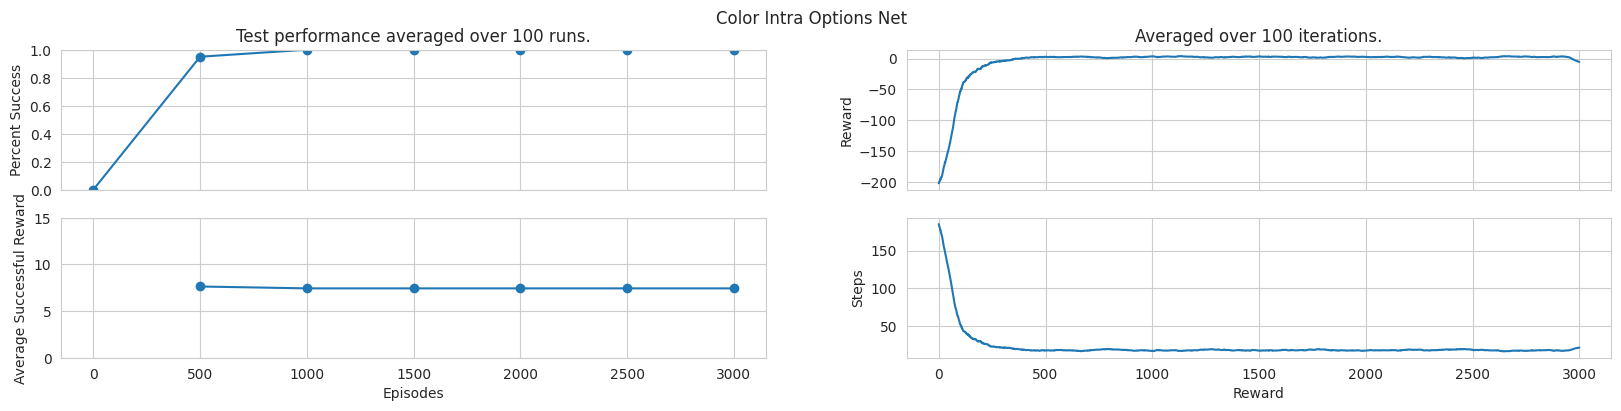

In [ ]:
rng = random.Random(seed)
net = ColorIntraOptionNet(
    n_states, n_actions, gamma=0.9, beta = 0.998, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='Color Intra Options Net')

curves["IntraOption with Color Options"] = (r_s, s_s, t_s)

from copy import deepcopy
intra_color_options_net = deepcopy(net)

  0%|          | 0/3000 [00:00<?, ?it/s]

<ipython-input-150-88b9e1f7a3c4>:46: RuntimeWarning: Mean of empty slice.
  test_s[int((i+1) // test_interval), :] = ((ts_s==200).sum() / test_iter, (tr_s[ts_s != 200]).mean())


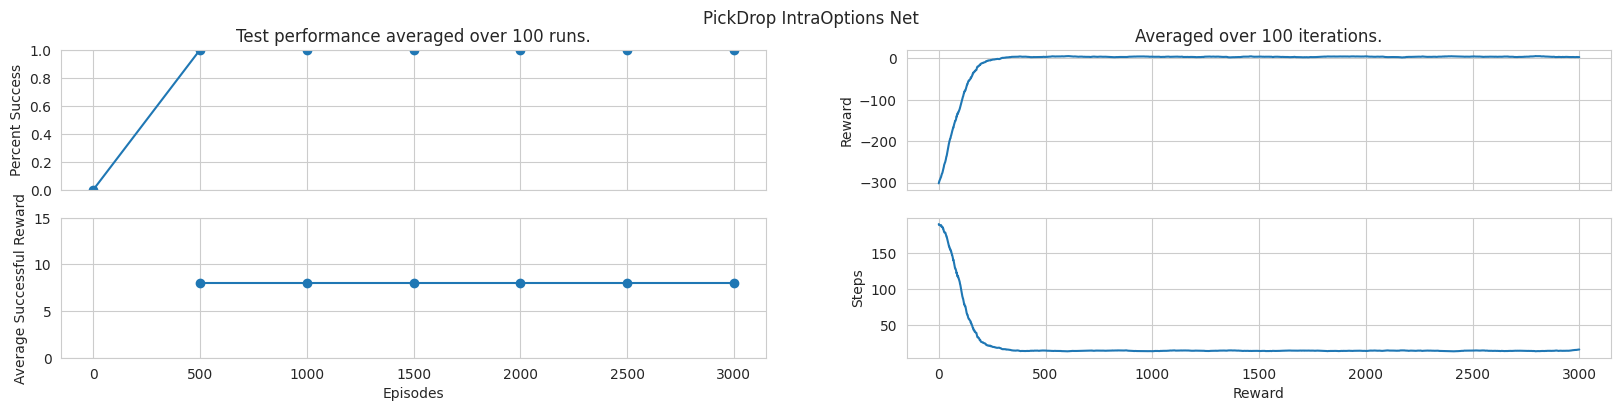

In [ ]:
rng = random.Random(seed)
net = PickDropIntraNet(
    n_states, n_actions, gamma=0.9,beta = 0.998, alpha=0.1, epsilon=0.1, seed=rng.getrandbits(32)
)

r_s, s_s, t_s = runner(net, N_ep=N_ep, rng=rng, do_test=test_param)
plot_perf(r_s, s_s, test_param, t_s, title='PickDrop IntraOptions Net')

curves["IntraOption with PickDrop Options"] = (r_s, s_s, t_s)

from copy import deepcopy
intra_pickdrop_options_net = deepcopy(net)

# Plotting

## Performance Visualization

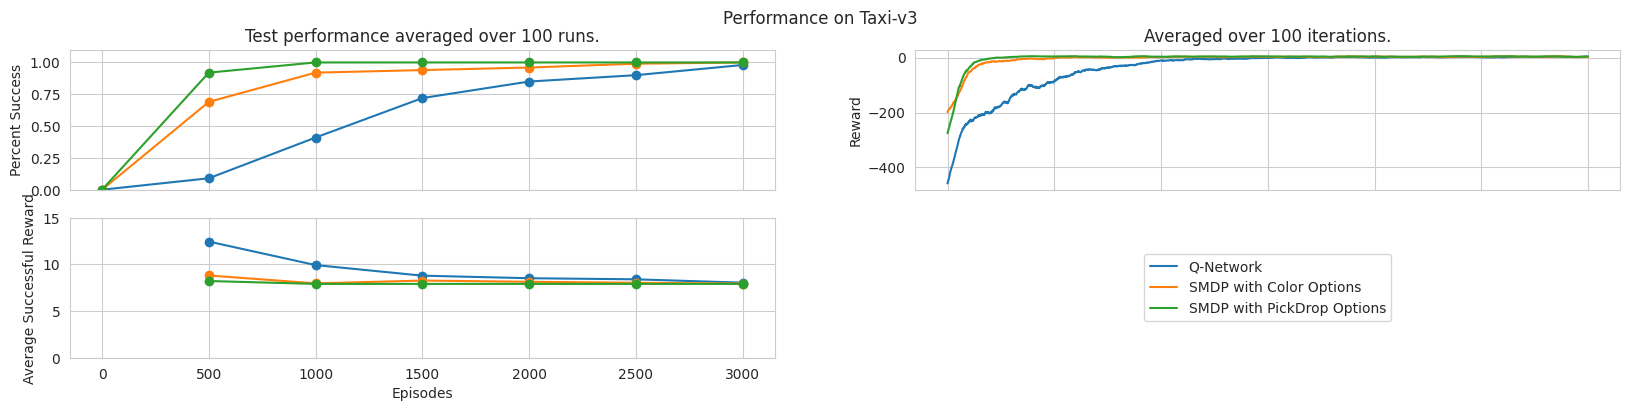

In [ ]:
# curves_to_show = {k:v for k,v in curves.items() if 'SMDP with C' in k or 'Q-Network' == k or 'Handmade' in k}
curves_to_show = {
    'Q-Network': curves['Q-Network'],
    'SMDP with Color Options': curves['SMDP with Color Options'],
    'SMDP with PickDrop Options': curves['SMDP with PickDrop Options'],
}
name_s = curves_to_show.keys()
r_s_s, s_s_s, t_s_s = zip(*curves_to_show.values())
plot_all_perf(name_s, r_s_s, s_s_s, test_param, t_s_s, title="Performance on Taxi-v3")

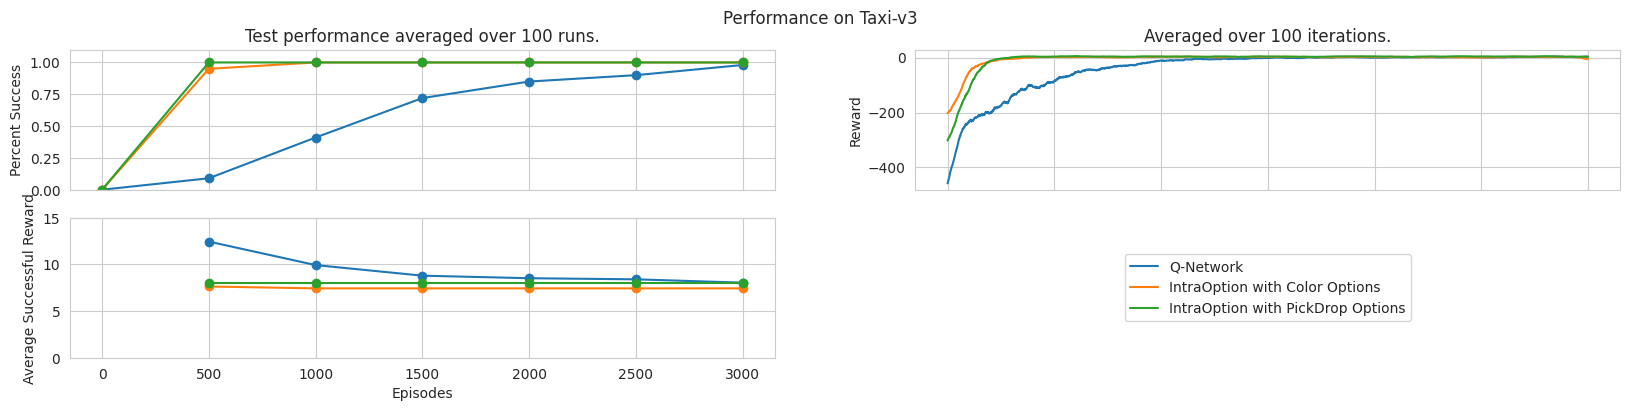

In [ ]:
# curves_to_show = {k:v for k,v in curves.items() if 'IntraOption with C' in k or 'Q-Network' == k or 'Handmade' in k}
curves_to_show = {
    'Q-Network': curves['Q-Network'],
    'IntraOption with Color Options': curves['IntraOption with Color Options'],
    'IntraOption with PickDrop Options': curves['IntraOption with PickDrop Options'],
}
name_s = curves_to_show.keys()
r_s_s, s_s_s, t_s_s = zip(*curves_to_show.values())
plot_all_perf(name_s, r_s_s, s_s_s, test_param, t_s_s, title="Performance on Taxi-v3")

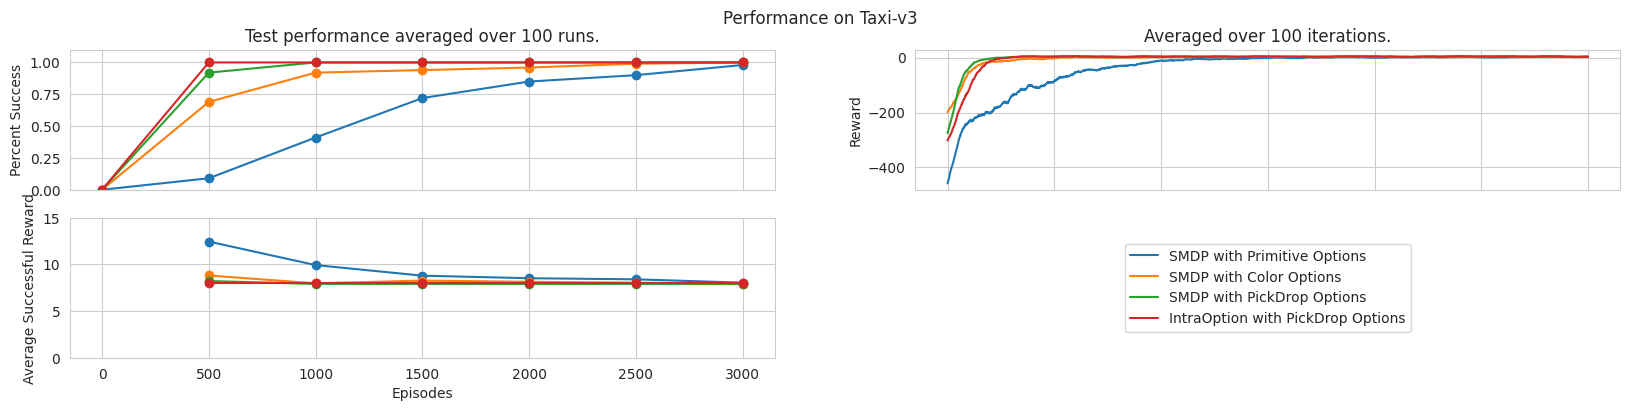

In [ ]:
curves_to_show = {k:v for k,v in curves.items() if 'Basic' not in k and 'Q-' not in k  and 'Hand' not in k and 'Intra' not in k or 'Pick' in k }
name_s = curves_to_show.keys()
r_s_s, s_s_s, t_s_s = zip(*curves_to_show.values())
plot_all_perf(name_s, r_s_s, s_s_s, test_param, t_s_s, title="Performance on Taxi-v3")

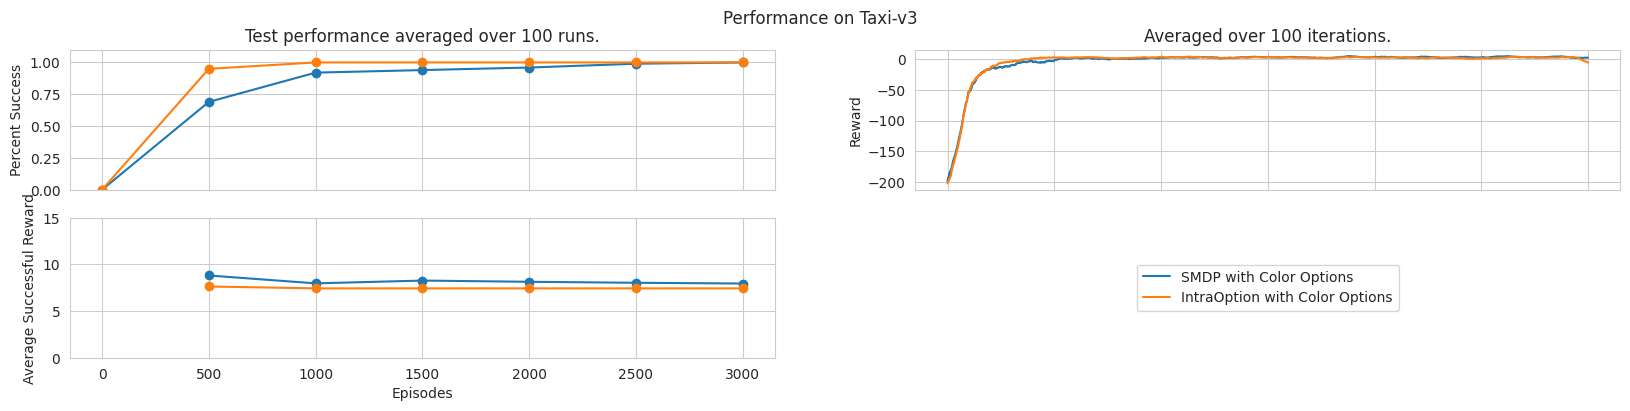

In [ ]:
# curves_to_show = {k:v for k,v in curves.items() if 'SMDP with C' in k or 'Q-Network' == k or 'Handmade' in k}
curves_to_show = {
    'SMDP with Color Options': curves['SMDP with Color Options'],
    'IntraOption with Color Options': curves['IntraOption with Color Options'],
}
name_s = curves_to_show.keys()
r_s_s, s_s_s, t_s_s = zip(*curves_to_show.values())
plot_all_perf(name_s, r_s_s, s_s_s, test_param, t_s_s, title="Performance on Taxi-v3")

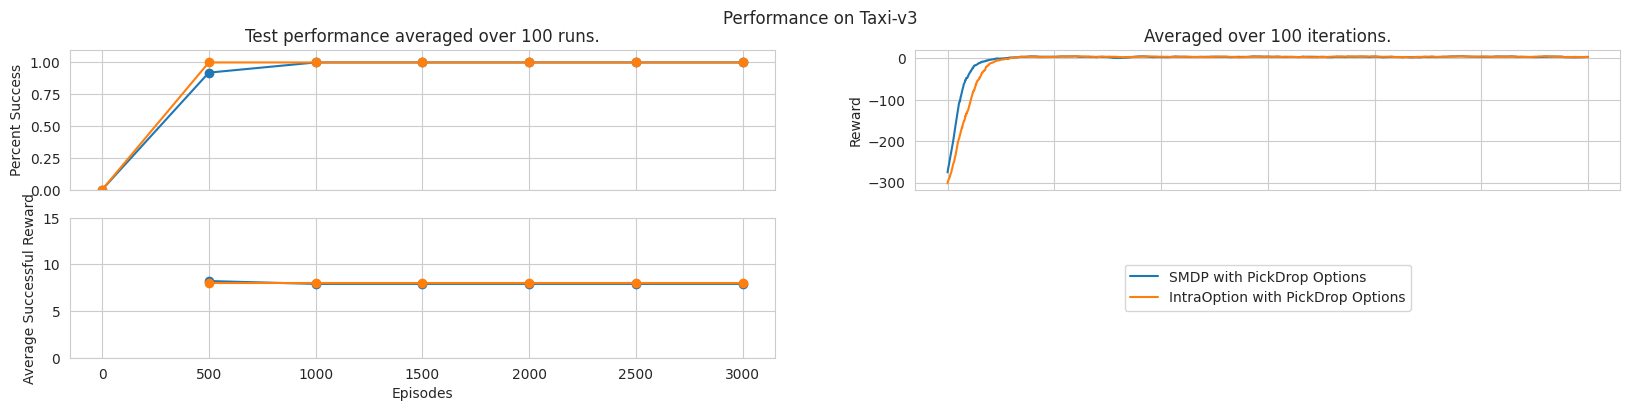

In [ ]:
# curves_to_show = {k:v for k,v in curves.items() if 'SMDP with C' in k or 'Q-Network' == k or 'Handmade' in k}
curves_to_show = {
    'SMDP with PickDrop Options': curves['SMDP with PickDrop Options'],
    'IntraOption with PickDrop Options': curves['IntraOption with PickDrop Options'],
}
name_s = curves_to_show.keys()
r_s_s, s_s_s, t_s_s = zip(*curves_to_show.values())
plot_all_perf(name_s, r_s_s, s_s_s, test_param, t_s_s, title="Performance on Taxi-v3")

## Policy Visualization

Text(0.5, 0.98, 'The Value and Policy function for each Color Option')

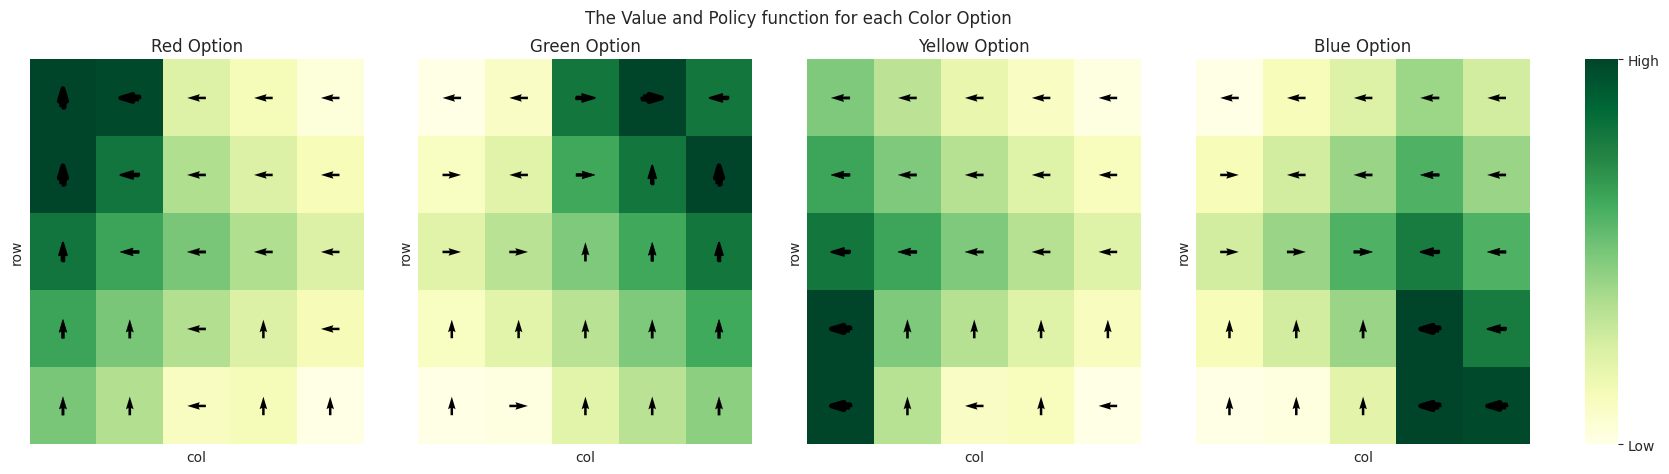

In [ ]:
from matplotlib import colors

dirs = np.array([
    (-1, 0),
    (0, 1),
    (1, 0),
    (-1, 0),
])

def draw_2d_policy(ax, values, actions, title=None, cbar=False, cbar_ax=None):
    sns.heatmap(values, cmap='YlGn', ax=ax, xticklabels=False, yticklabels=False, cbar=cbar, cbar_ax=cbar_ax)
    ax.set_xlabel('col')
    ax.set_ylabel('row')

    x, y = np.arange(0, 5, 1) + 0.5, np.arange(0, 5, 1) + 0.5
    x, y = np.meshgrid(x, y)
    # print(values.max())
    values = (values - values.min()) / (values.max() - values.min()) / 1.1
    ax.quiver(x, y, dirs[actions][:, :, 0], dirs[actions][:, :, 1], pivot='middle', linewidths=values.ravel()**4 * 5, edgecolors='k')
    # scale_units='xy', scale=1,
    if title is not None:
        ax.set_title(title)

fig, axs = plt.subplots(1, 5, figsize=(20 * 4.1/4, 5), width_ratios=(1, 1, 1, 1, 0.1))

color_opts = color_options_net.options[:-2]
for i, (opt, ax) in enumerate(zip(color_opts, axs)):
    q = opt.net.q
    values = q.reshape(5, 5, -1).max(-1)
    action = q.reshape(5, 5, -1).argmax(-1)
    draw_2d_policy(ax, values, action, cbar=(ax == axs[-2]), cbar_ax=(None if ax != axs[-2] else axs[-1]),
                   title=f"{State.destination_location_map[i]} Option")
    if ax == axs[-2]:
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([values.min(), values.max()])
        cbar.set_ticklabels(['Low', 'High'])


fig.suptitle("The Value and Policy function for each Color Option")


Text(0.5, 0.98, 'The Value and Policy function for each Color Option')

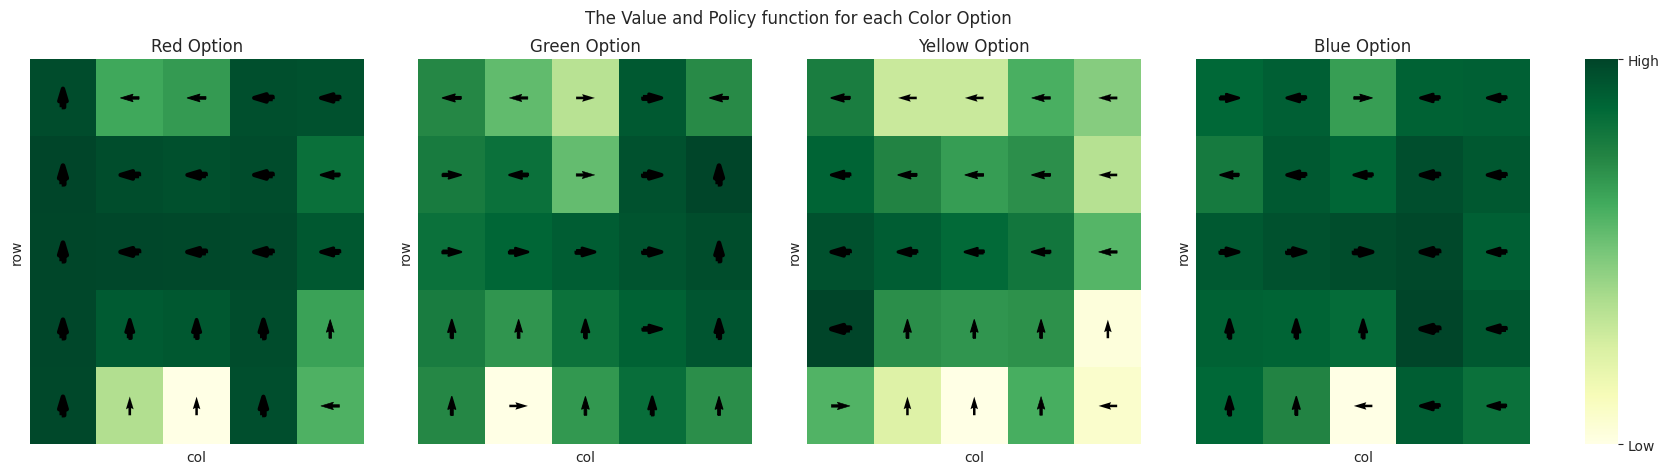

In [ ]:
from matplotlib import colors

dirs = np.array([
    (-1, 0),
    (0, 1),
    (1, 0),
    (-1, 0),
])

def draw_2d_policy(ax, values, actions, title=None, cbar=False, cbar_ax=None):
    sns.heatmap(values, cmap='YlGn', ax=ax, xticklabels=False, yticklabels=False, cbar=cbar, cbar_ax=cbar_ax)
    ax.set_xlabel('col')
    ax.set_ylabel('row')

    x, y = np.arange(0, 5, 1) + 0.5, np.arange(0, 5, 1) + 0.5
    x, y = np.meshgrid(x, y)
    # print(values.max())
    values = (values - values.min()) / (values.max() - values.min()) / 1.1
    ax.quiver(x, y, dirs[actions][:, :, 0], dirs[actions][:, :, 1], pivot='middle', linewidths=values.ravel()**4 * 5, edgecolors='k')
    # scale_units='xy', scale=1,
    if title is not None:
        ax.set_title(title)
fig, axs = plt.subplots(1, 5, figsize=(20 * 4.1/4, 5), width_ratios=(1, 1, 1, 1, 0.1))

color_opts = intra_color_options_net.options[:-2]
for i, (opt, ax) in enumerate(zip(color_opts, axs)):
    q = opt.net.q
    values = q.reshape(5, 5, -1).max(-1)
    action = q.reshape(5, 5, -1).argmax(-1)
    draw_2d_policy(ax, values, action, cbar=(ax == axs[-2]), cbar_ax=(None if ax != axs[-2] else axs[-1]),
                   title=f"{State.destination_location_map[i]} Option")
    if ax == axs[-2]:
        cbar = ax.collections[0].colorbar
        cbar.set_ticks([values.min(), values.max()])
        cbar.set_ticklabels(['Low', 'High'])


fig.suptitle("The Value and Policy function for each Color Option")



Text(0.5, 0.98, 'SMDP Policy')

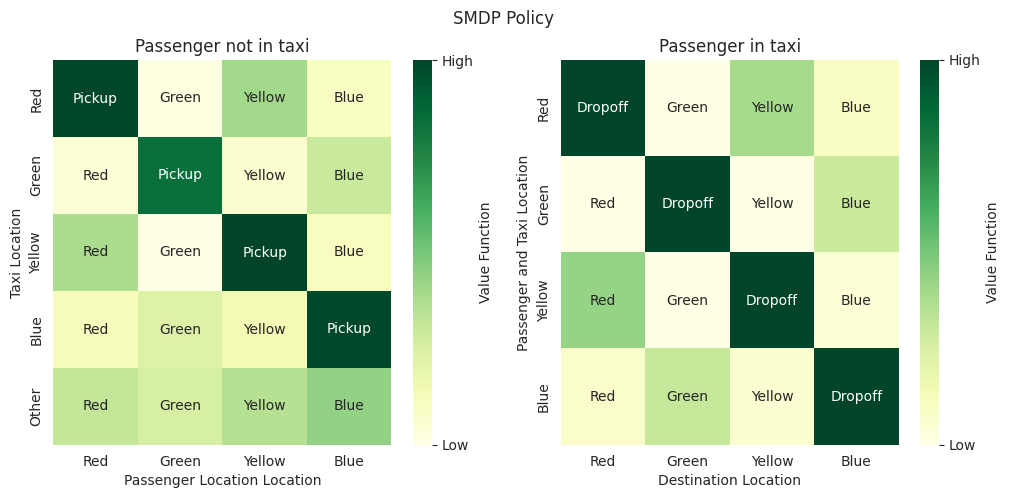

In [ ]:
net = color_options_net

color_avalues = net.net.q.reshape(5, 5, 4, 6)
color_avalues -= color_avalues.min()
table_1 = color_avalues[:, :-1, :, :].mean(axis=2).argmax(-1)
table_1v = color_avalues[:, :-1, :, :].mean(axis=2).max(-1)
table_2 = color_avalues[:-1, -1, :, :].argmax(-1)
table_2v = color_avalues[:-1, -1, :, :].max(-1)

actions = np.array('Red Green Yellow Blue Pickup Dropoff'.split(' '), dtype=object)


f, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
sns.heatmap(table_1v, xticklabels='Red Green Yellow Blue'.split(' '), yticklabels='Red Green Yellow Blue Other'.split(' '),
            annot=actions[table_1], fmt = '', ax=ax, cbar_kws={'label': 'Value Function'}, cmap='YlGn')
ax.set_xlabel('Passenger Location Location')
ax.set_ylabel('Taxi Location')
ax.set_title('Passenger not in taxi')
cbar = ax.collections[0].colorbar
cbar.set_ticks([table_1v.min(), table_1v.max()])
cbar.set_ticklabels(['Low', 'High'])

ax = axs[1]
sns.heatmap(table_2v, xticklabels='Red Green Yellow Blue'.split(' '), yticklabels='Red Green Yellow Blue'.split(' '),
            annot=actions[table_2], fmt = '', ax=ax, cbar_kws={'label': 'Value Function'}, cmap='YlGn')

cbar = ax.collections[0].colorbar
cbar.set_ticks([table_2v.min(), table_2v.max()])
cbar.set_ticklabels(['Low', 'High'])

ax.set_title('Passenger in taxi')
ax.set_xlabel('Destination Location')
ax.set_ylabel('Passenger and Taxi Location')

f.suptitle('SMDP Policy')

Text(0.5, 0.98, 'IntraOption Policy')

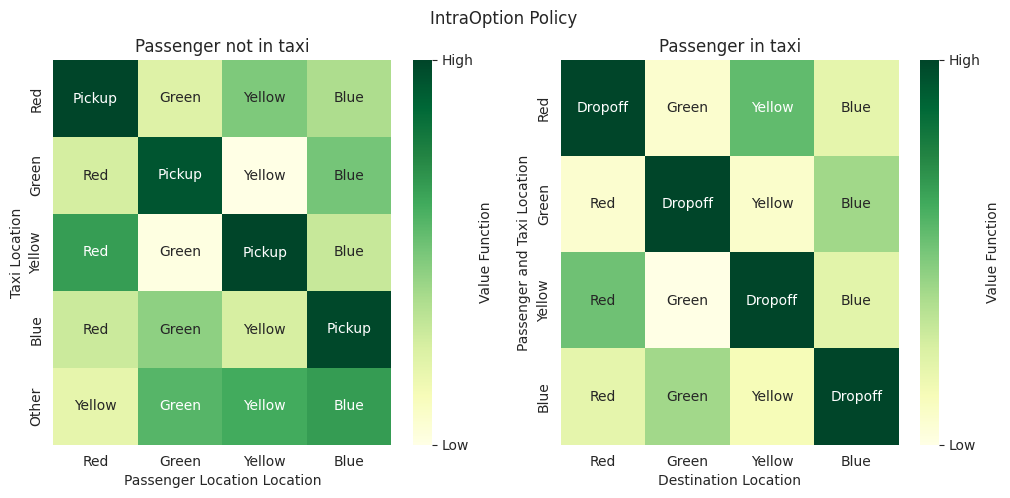

In [ ]:
net = intra_color_options_net

color_avalues = net.net.q.reshape(5, 5, 4, 6)
color_avalues -= color_avalues.min()
table_1 = color_avalues[:, :-1, :, :].mean(axis=2).argmax(-1)
table_1v = color_avalues[:, :-1, :, :].mean(axis=2).max(-1)
table_2 = color_avalues[:-1, -1, :, :].argmax(-1)
table_2v = color_avalues[:-1, -1, :, :].max(-1)

actions = np.array('Red Green Yellow Blue Pickup Dropoff'.split(' '), dtype=object)


f, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
sns.heatmap(table_1v, xticklabels='Red Green Yellow Blue'.split(' '), yticklabels='Red Green Yellow Blue Other'.split(' '),
            annot=actions[table_1], fmt = '', ax=ax, cbar_kws={'label': 'Value Function'}, cmap='YlGn')
ax.set_xlabel('Passenger Location Location')
ax.set_ylabel('Taxi Location')
ax.set_title('Passenger not in taxi')
cbar = ax.collections[0].colorbar
cbar.set_ticks([table_1v.min(), table_1v.max()])
cbar.set_ticklabels(['Low', 'High'])

ax = axs[1]
sns.heatmap(table_2v, xticklabels='Red Green Yellow Blue'.split(' '), yticklabels='Red Green Yellow Blue'.split(' '),
            annot=actions[table_2], fmt = '', ax=ax, cbar_kws={'label': 'Value Function'}, cmap='YlGn')

cbar = ax.collections[0].colorbar
cbar.set_ticks([table_2v.min(), table_2v.max()])
cbar.set_ticklabels(['Low', 'High'])

ax.set_title('Passenger in taxi')
ax.set_xlabel('Destination Location')
ax.set_ylabel('Passenger and Taxi Location')

f.suptitle('IntraOption Policy')

Text(0.5, 1.0, 'SMDP Value Function')

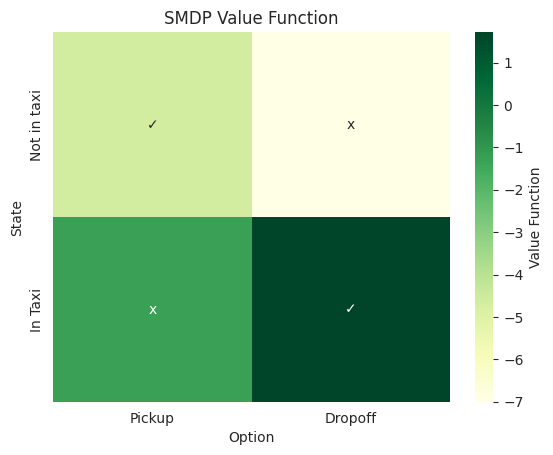

In [ ]:
net = pickdrop_options_net

pickdrop_avalues = net.net.q


annot = [
    ["✓", "x"],
    ["x", "✓"]
]
sns.heatmap(pickdrop_avalues, xticklabels='Pickup Dropoff'.split(' '), yticklabels='Not in taxi_In Taxi'.split('_'),
            annot=annot, fmt='', cbar_kws={'label': 'Value Function'}, cmap='YlGn')

plt.xlabel('Option')
plt.ylabel('State')
plt.title('SMDP Value Function')

Text(0.5, 1.0, 'IntraOption Value Function')

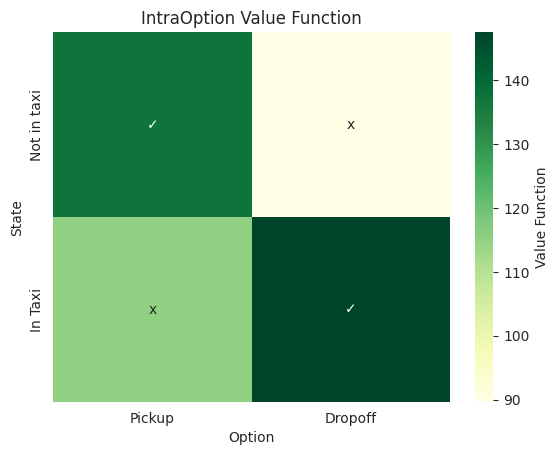

In [ ]:
net = intra_pickdrop_options_net

pickdrop_avalues = net.net.q


annot = [
    ["✓", "x"],
    ["x", "✓"]
]
sns.heatmap(pickdrop_avalues, xticklabels='Pickup Dropoff'.split(' '), yticklabels='Not in taxi_In Taxi'.split('_'),
            annot=annot, fmt='', cbar_kws={'label': 'Value Function'}, cmap='YlGn')

plt.xlabel('Option')
plt.ylabel('State')
plt.title('IntraOption Value Function')